In [128]:
import torch as th
import numpy as np
from matplotlib import pyplot as plt

In [129]:
save_as = "not_reg_1024"
suptitle = "mapper"
title = "mapper"

In [130]:
hidden_activations = th.load(f"./activations/hidden_activ_{save_as}.pt")
output_activations = th.load(f"./activations/output_activ_{save_as}.pt")
predicted = th.load(f"./predicted/{save_as}.pt")

hidden_activations = hidden_activations.numpy()
output_activations = output_activations.numpy()
predicted = predicted.numpy()

In [131]:
hidden_layer_neurons = hidden_activations.shape[1]

## Compute mapper

It performs mapper algorithm and return:

- a html file inside mapper_outputs folder to see the resulting graph
- indexes_from_cluster_output, data_from_cluster_output variables, which stores respectively:
  - the indexes of the test point in each cluster
  - the activations (so a vector of 10 or 100 elements, depending if outputor hidden) of the test point in each cluster


In [132]:
from src.compute_mapper import compute_mapper
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

indexes_from_cluster_output, data_from_cluster_output = compute_mapper(
    data=output_activations,
    title="output activations",
    n_cubes=15,
    cube=14,
    save_as=save_as,
)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: max
	Distance matrices: None
	Scalers: StandardScaler()
..Projecting on data shaped (10000, 10)

..Projecting data using: max

..Scaling with: StandardScaler()

Mapping on data shaped (10000, 10) using lens shaped (10000, 1)

Creating 15 hypercubes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '


Created 144 edges and 120 nodes in 0:00:01.347361.
Wrote visualization to: plot_outputs/mapper/mapper_outputs/not_reg_1024.html


In [133]:
associations = (
    []
)  # associations[i] is a tuple with the label associated with i-th cluster, with the given probability
for i in range(10):
    labels, freq = np.unique(
        predicted[indexes_from_cluster_output[i]], return_counts=True
    )
    print(
        f"CLUSTER {i}. Labels:{labels}. Frequency: {freq} ---> Cluster {i} associated with label {labels[np.argmax(freq)]} with prob. {100*np.max(freq)/np.sum(freq)}%"
    )
    associations.append((labels[np.argmax(freq)], np.max(freq) / np.sum(freq)))

CLUSTER 0. Labels:[0 2 5]. Frequency: [322   1   1] ---> Cluster 0 associated with label 0 with prob. 99.38271604938272%
CLUSTER 1. Labels:[0 1 2 3 4 5 6 7 8 9]. Frequency: [132 151 178 140 307 134  92 105 753 725] ---> Cluster 1 associated with label 8 with prob. 27.71439087228561%
CLUSTER 2. Labels:[1 2 4 7]. Frequency: [627   1  24   7] ---> Cluster 2 associated with label 1 with prob. 95.14415781487102%
CLUSTER 3. Labels:[0 4 5 6]. Frequency: [  1   5   7 498] ---> Cluster 3 associated with label 6 with prob. 97.4559686888454%
CLUSTER 4. Labels:[2 6]. Frequency: [  1 275] ---> Cluster 4 associated with label 6 with prob. 99.6376811594203%
CLUSTER 5. Labels:[1 3 4 5 7 8 9]. Frequency: [  4 391  15 372 389   1   2] ---> Cluster 5 associated with label 3 with prob. 33.30494037478705%
CLUSTER 6. Labels:[0 2 5 6]. Frequency: [490   3   1   2] ---> Cluster 6 associated with label 0 with prob. 98.79032258064517%
CLUSTER 7. Labels:[3 5 7]. Frequency: [203 125   2] ---> Cluster 7 associated

### Next step

Prendo i cluster dati da mapper nell output layer.
Per ogni cluster, prendo gli indici dei test point che stanno in que cluster (indexes_from_cluster_output).

Poi, vado a vedere le hidden activations per questi testpoint che stanno dentro lo stesso cluster.


In [134]:
# store the hidden activations for each of the 10 cluster:
hidden_activ_per_clusters = []

for i in range(10):
    # indexes_from_cluster_output[i]

    # seleziono le hidden activation dei test point corrispondenti
    hidden_activ_per_clusters.append(hidden_activations[indexes_from_cluster_output[i]])

Ora:

- per ogni cluster:
  - per ogni elemento in un cluster:
    - considero le sue hidden activations e seleziono gli indexes delle 5 attivazioni piu grandi (che corrispondono ai neuroni dell'hidden layer che si attivano di piu per i test point che poi vanno a finire in quel cluster)


In [135]:
top_activations = [[] for _ in range(10)]
for i in range(10):
    for j in range(hidden_activ_per_clusters[i].shape[0]):
        top_activations[i].append(hidden_activ_per_clusters[i][j].argsort()[-5:][::-1])

in DICT[0] c'è il seguente: \
ci sono le top 5 HIDDEN activations per ogni test point che sta dentro il cluster 0.


In [136]:
neurons_IDs = []  # gli interi qui dentro corrispondono all'ID di un neurone
frequencies = []

for i in range(10):
    values, counts = np.unique(
        np.stack(top_activations[i]).flatten(), return_counts=True
    )
    neurons_IDs.append(values)
    frequencies.append(counts)

in unique_values[0], frequencies[0] ci sono gli indici degli hidden layer che sono collegati a un qualce test point nel cluster 0, con relative frequenze.

Alla fine della fiera questo è cio che succede: \
faccio i cluster con mapper \
prendo il primo cluster (cluster 0) \
ritrovo i test point che appartengono a quel cluster \
per ogni test point, ritrovo le 5 hidden activation piu alte collegate a quel test point, e questo lo faccio per ogni test point nel cluster (cluster 0) \
alla fine conto le frequenze di questi neuroni nell'hidden layer per vedere se c'è qualche pattern: cluster 0-neuroni nell hidden layer che vengono attiavti piu di frequente.


In [137]:
best_neurons_per_cluster = []
for i in range(10):
    idxs = list(frequencies[i].argsort()[-5:][::-1])
    best_neurons_per_cluster.append(neurons_IDs[i][idxs])

best_neurons_per_cluster

[array([840, 278, 785, 483,  71]),
 array([945, 354, 234, 296, 455]),
 array([312, 445,  70,  56, 878]),
 array([987, 533,  55, 342, 360]),
 array([987, 533, 360, 342,  55]),
 array([310, 234, 931, 432, 371]),
 array([840, 278, 785,  71, 483]),
 array([ 310,  234,  432,  959, 1012]),
 array([878, 321, 371, 432, 840]),
 array([234, 945, 878, 371, 455])]

## Resulting plot


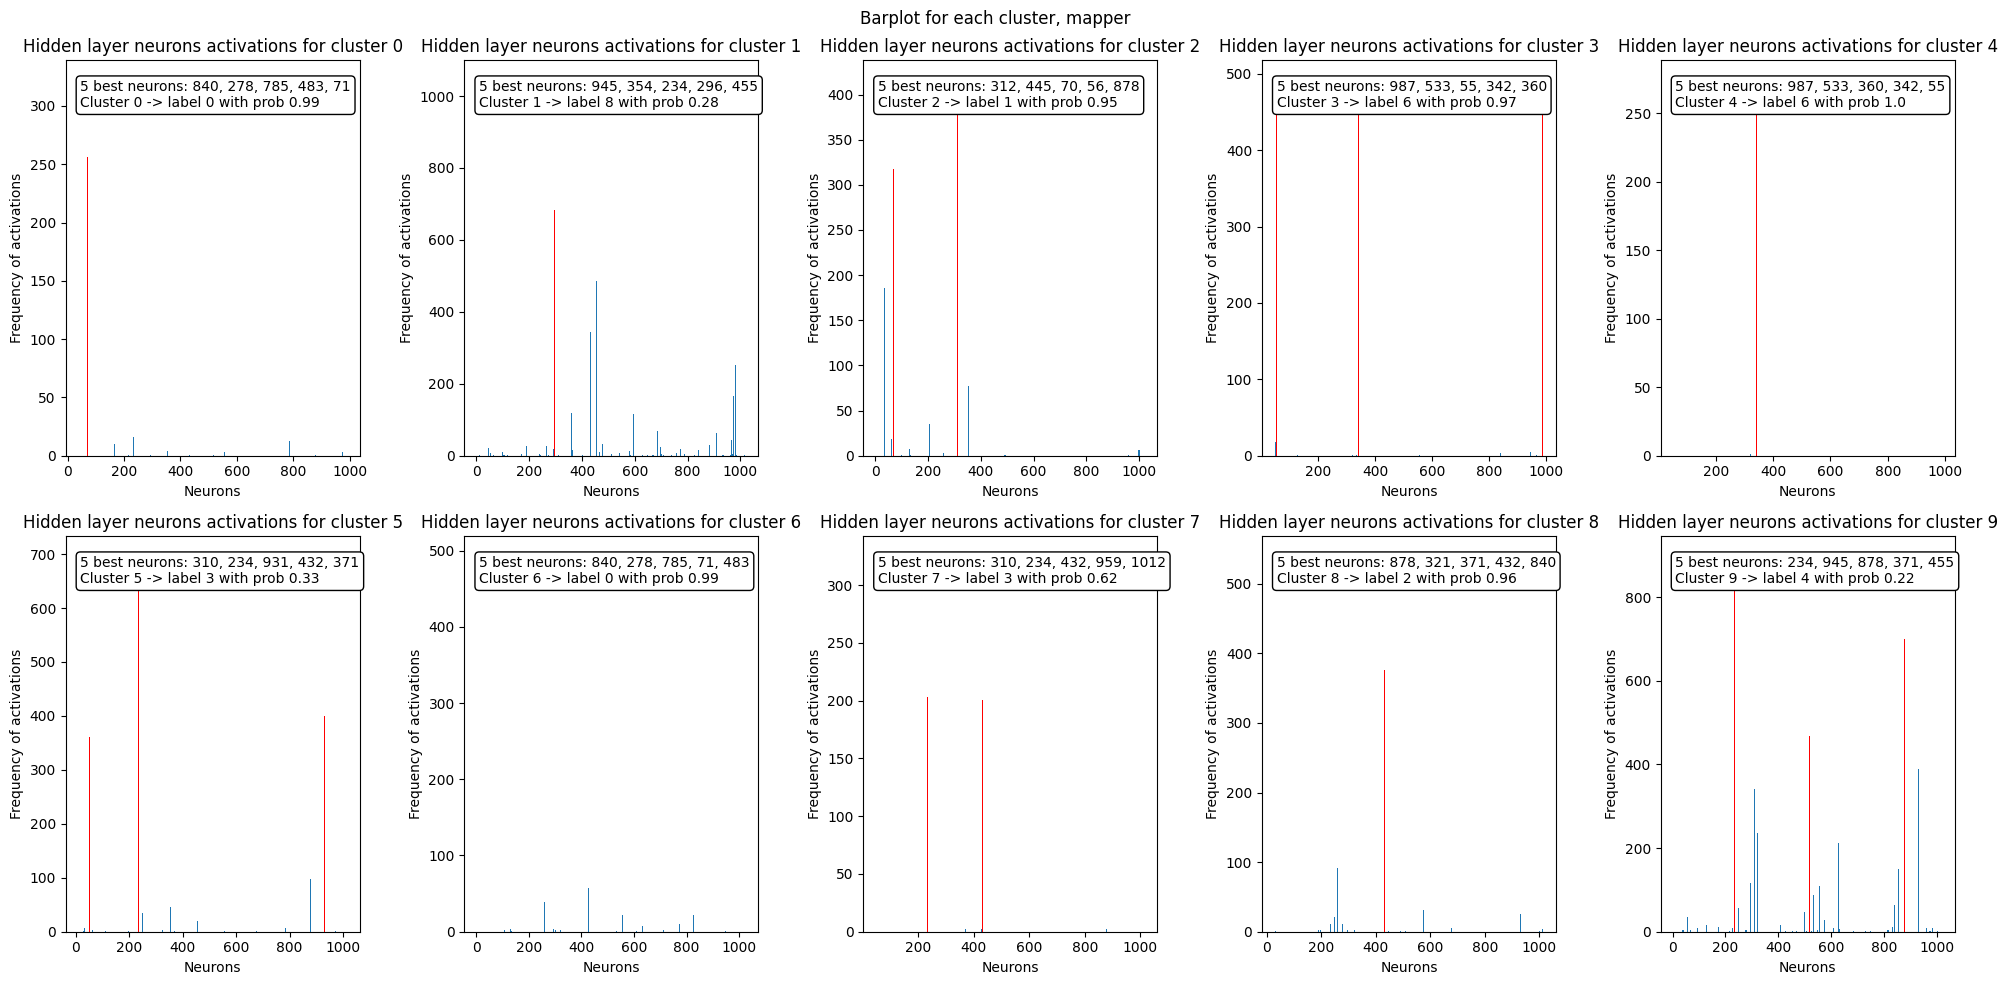

In [138]:
from src.evaluation import barplot_grid, heatmap

barplot_grid(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    suptitle=suptitle,
    save_as=save_as,
)

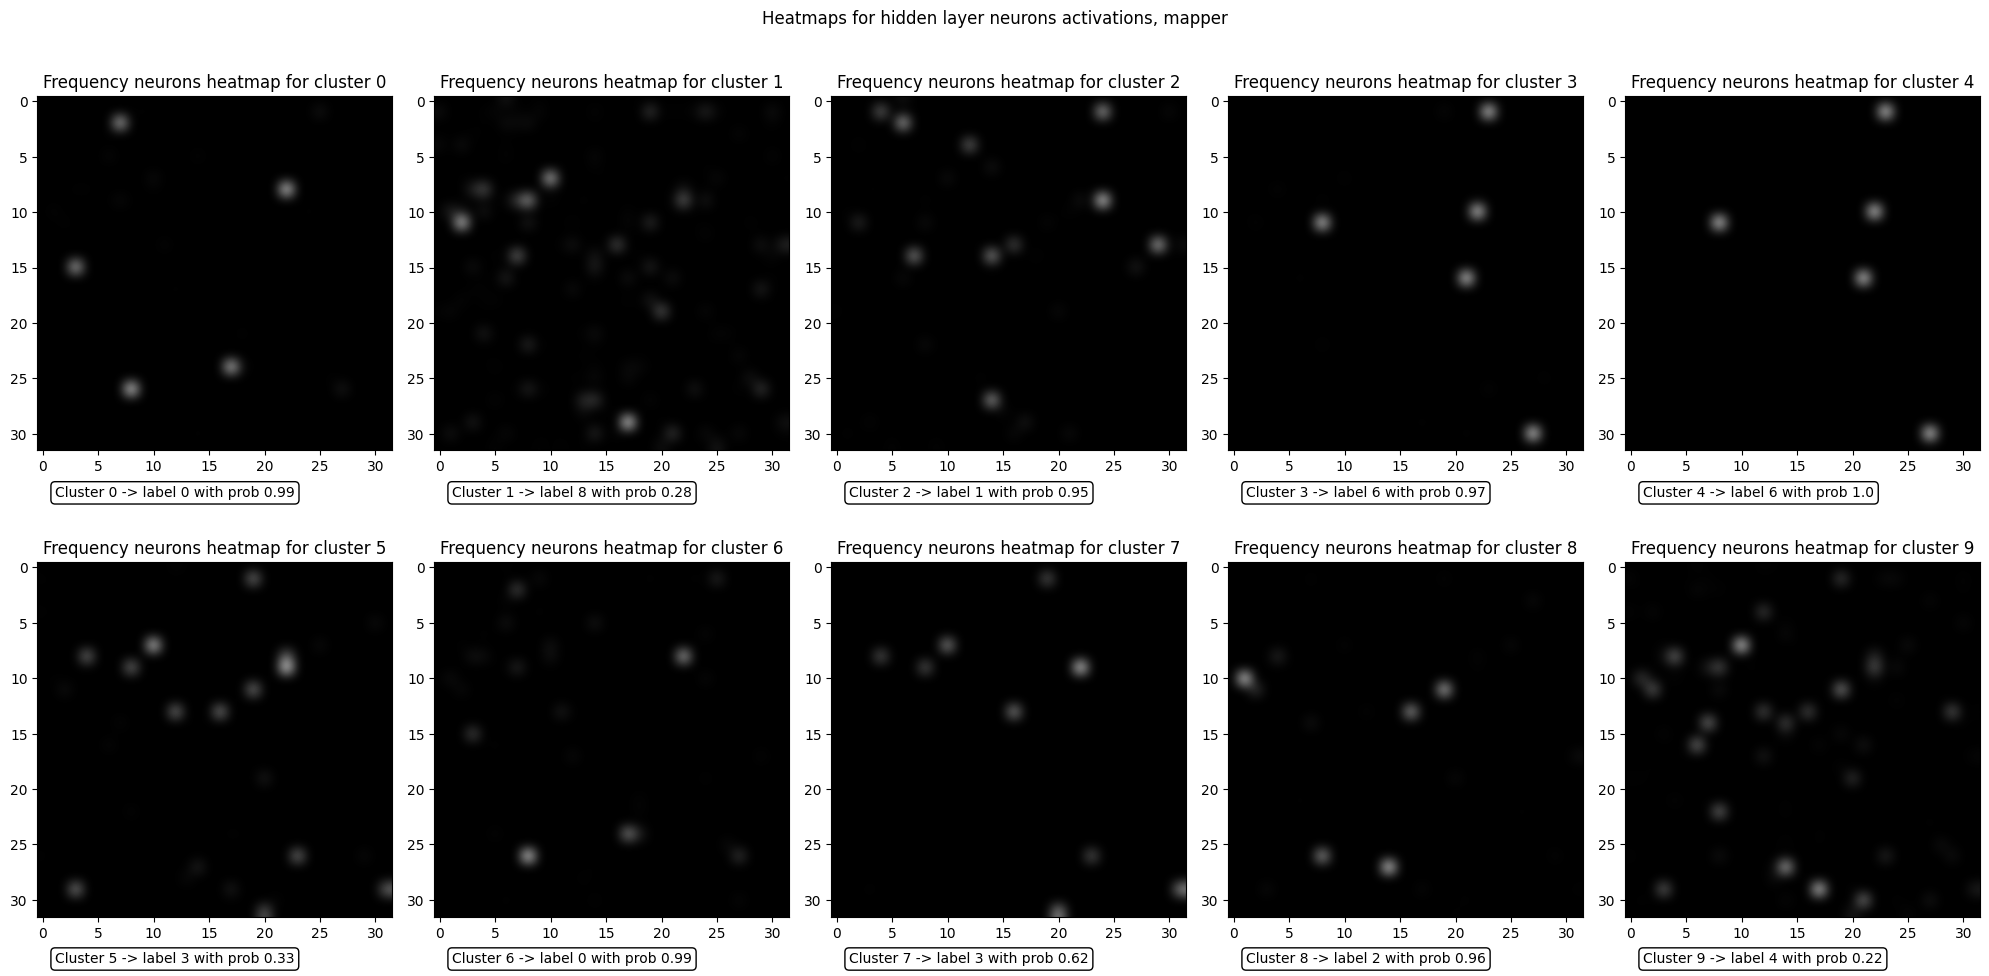

In [139]:
heatmap(
    neurons_IDs=neurons_IDs,
    frequencies=frequencies,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    suptitle=suptitle,
    save_as=save_as,
)

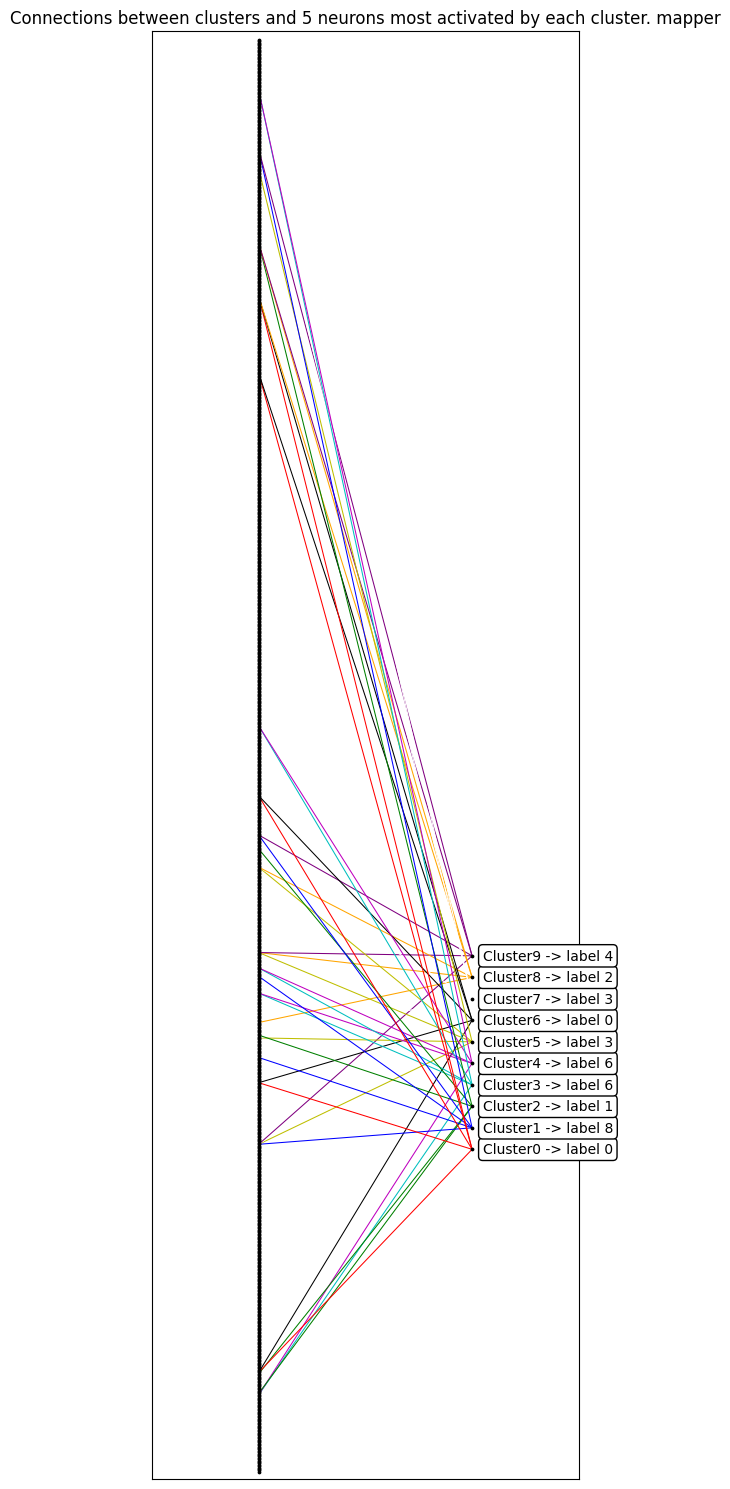

In [140]:
from src.evaluation import connections

connections(
    best_neurons_per_cluster=best_neurons_per_cluster,
    associations=associations,
    hidden_layer_neurons=hidden_layer_neurons,
    title=title,
    save_as=save_as,
)

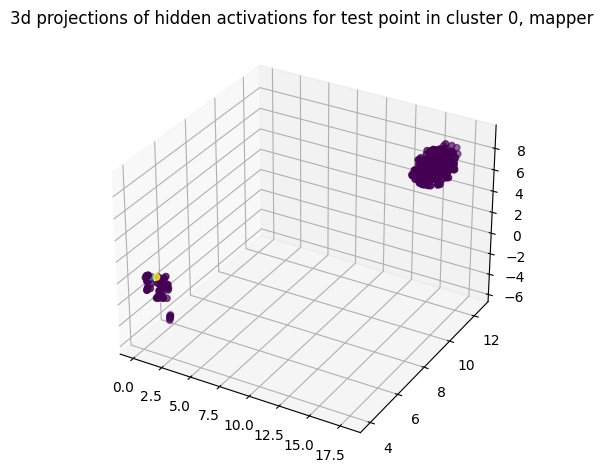

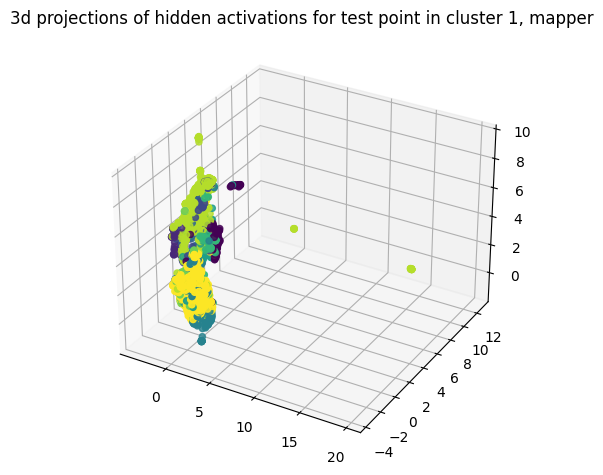

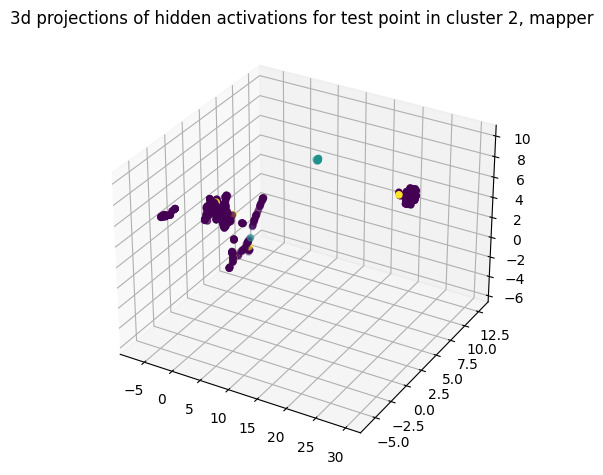

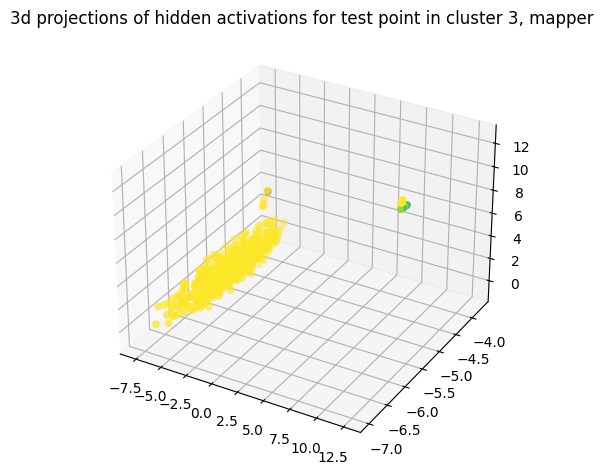

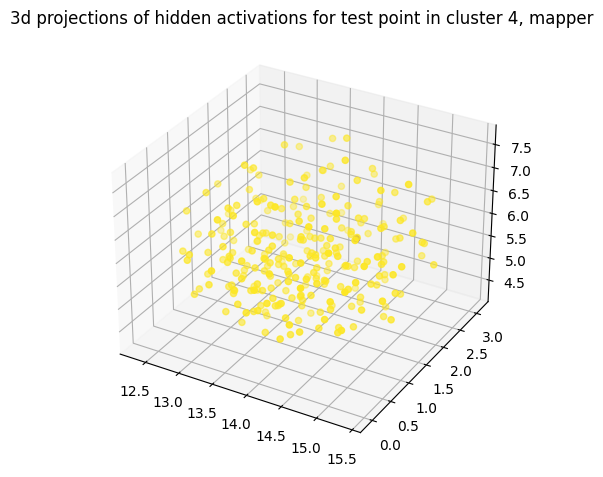

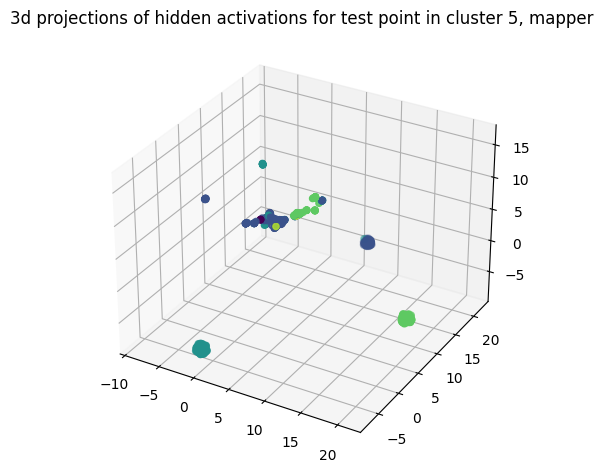

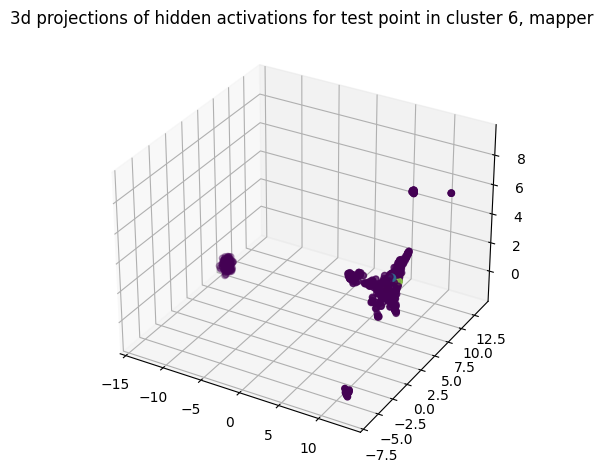

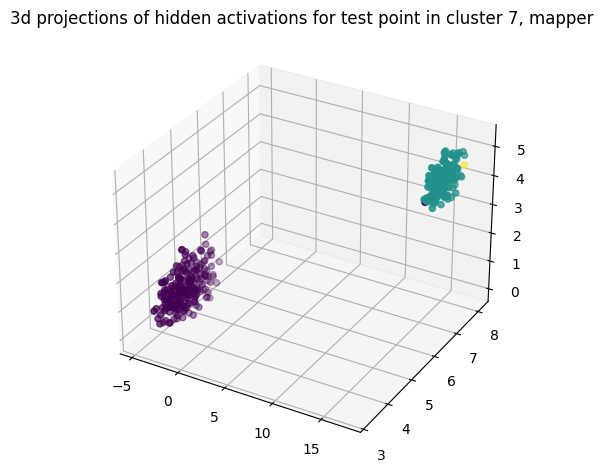

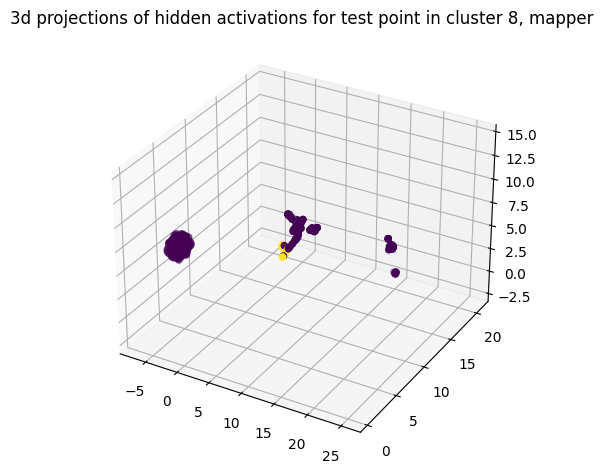

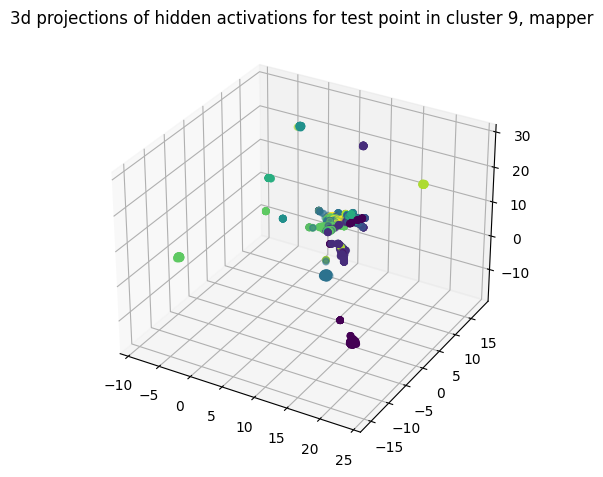

In [141]:
import matplotlib.pyplot as plt
from src.plot_manifold import plot_manifold


for i in range(10):
    plot_manifold(
        data=hidden_activations[indexes_from_cluster_output[i]],
        i=i,
        title=title,
        predicted=predicted[indexes_from_cluster_output[i]],
        save_as=save_as,
    )

    plt.show()

## Weights analysis


In [142]:
weights_first_layer = th.load(f"./weights/weights_first_layer_{save_as}.pt")

weights_first_layer = weights_first_layer.numpy()

weights_per_cluster = (
    []
)  # weights_per_cluster[i] stores the weights for the 5 'best' neurons in the i-th cluster. (nb consider the weights che uniscono il primo layer al neurone del secondo layer)
for i in range(10):
    weights_per_cluster.append(weights_first_layer[best_neurons_per_cluster[i]])

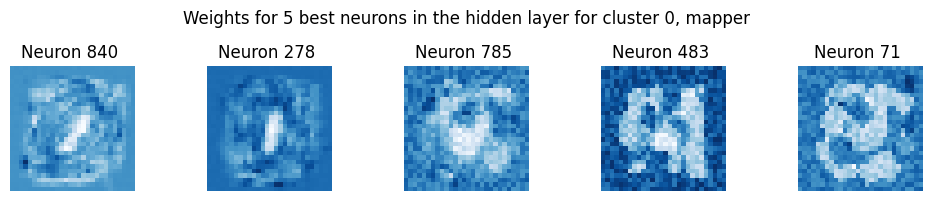

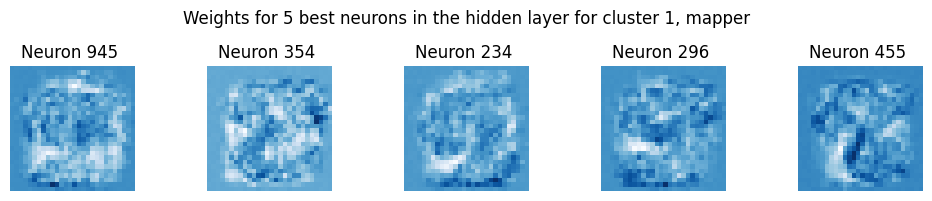

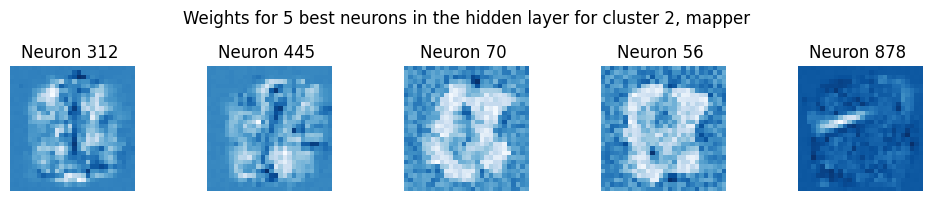

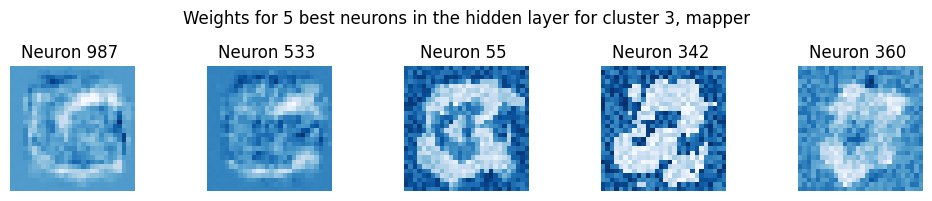

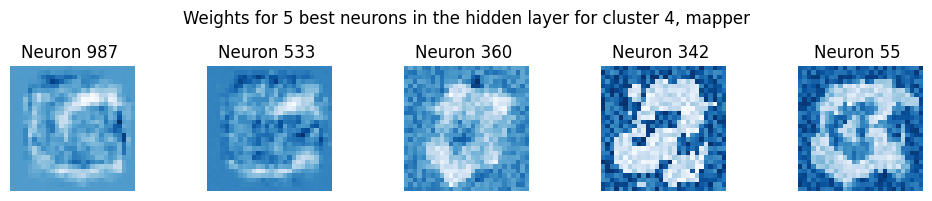

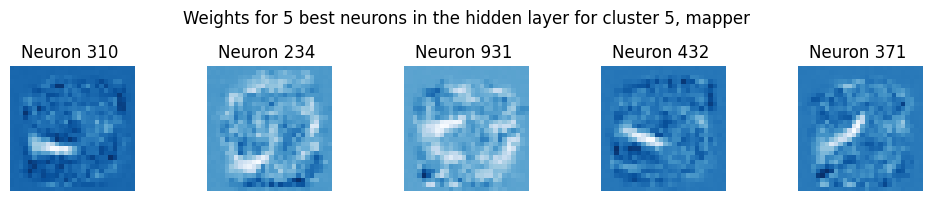

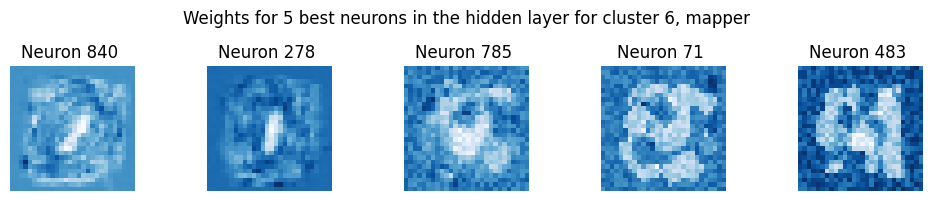

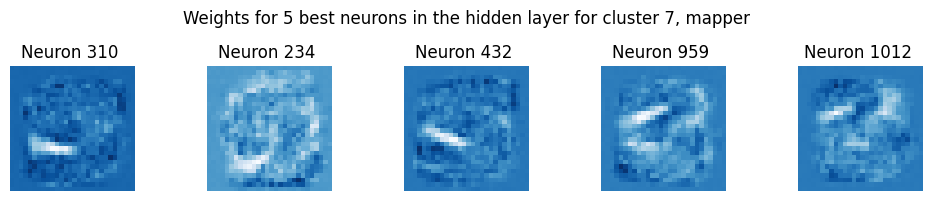

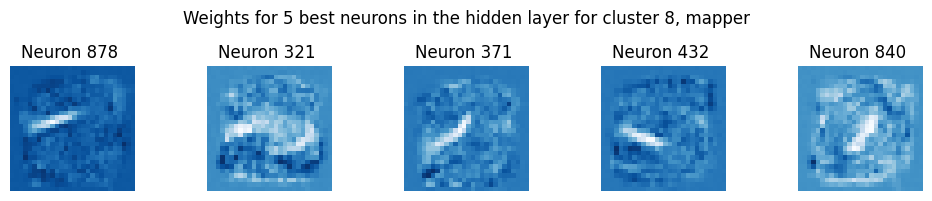

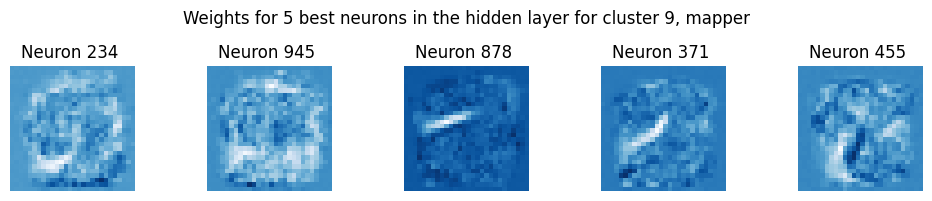

In [143]:
from src.evaluation import plot_weights

plot_weights(
    weights_per_cluster=weights_per_cluster,
    best_neurons_per_cluster=best_neurons_per_cluster,
    title=title,
    save_as=save_as,
)

In [144]:
%store -r test_loader

Take the first image (7), and study how the network 'see' this image by filtering using the corresponding best neurons from clusters associated with label 7.


image with index 3 has label 0, which is associated with cluster(s): [0, 6] 


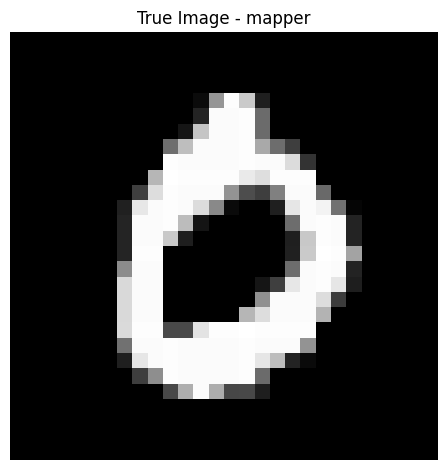

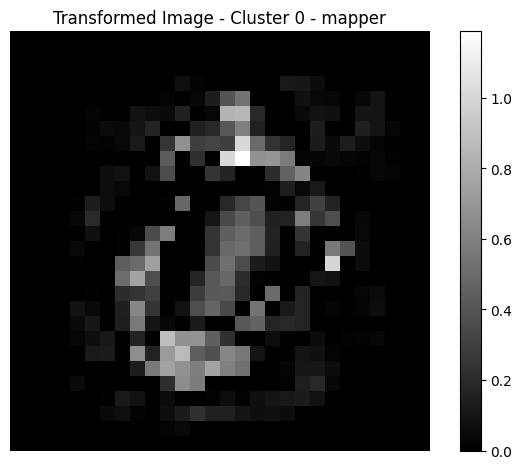

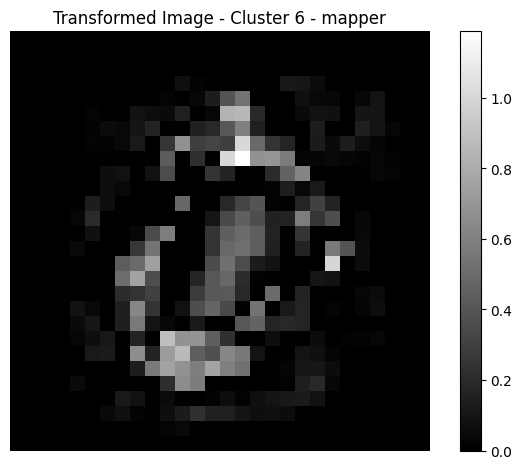

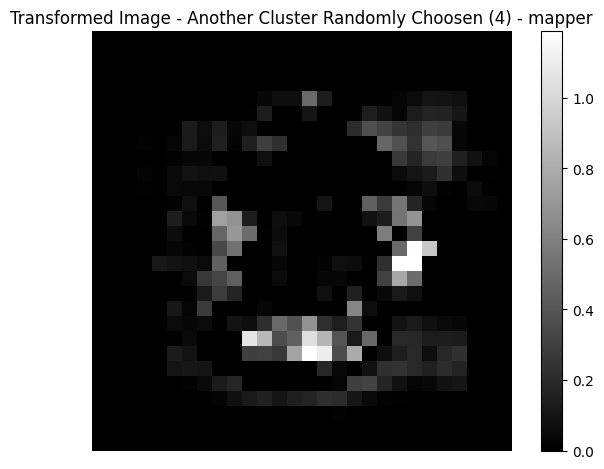

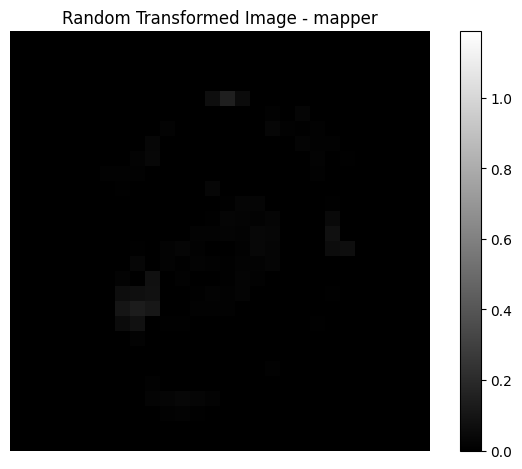

------------------------------------------------------------------------


In [146]:
from src.evaluation import neurons_reconstruction


neurons_reconstruction(
    image_index=3,
    test_loader=test_loader,
    associations=associations,
    weights_per_cluster=weights_per_cluster,
    weights_first_layer=weights_first_layer,
    save=True,
    save_as=save_as,
    title=title,
)